### About this assignment
This assignment is devoted to solving regression problem on taxi ride dataset, with features analysis and finding good features for prediction. Also here we meet with the libraries `seaborn` and `sklearn`.

In the assignment we will use `folium` library. Install it if necessary.

In [101]:
#pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [102]:
import folium

m = folium.Map(location=(53.0833684, 8.8137641), zoom_start=12)

m

If everything is OK then you should see a map of Bremen.

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

## Part 0. Data preparation (1 pts)

**Task 1 (1 pts)**. We are going to work with data from the competition [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), where one should predict taxi ride duration time. Download the training set from this competition and load it:

In [104]:
#Your code here
train = pd.read_csv('train.csv')
train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

Pay attention to the columns `pickup_datetime` and `dropoff_datetime`. `dropoff_datetime` was added by organizers only to the training set. So this column can't be used for prediction, let's delete it. In `pickup_datetime` you can find date and time of ride start. For convenience let's transform these dates to `datetime`-objects

In [105]:
#Your code here
train.drop('dropoff_datetime', axis=1, inplace=True)
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

In [106]:
train.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dtype: object

In [107]:
train.shape

(1458644, 10)

In the column `trip_duration` you can find target values for prediction. Let's look at target distribution on the training set. Plot the histogram for this:

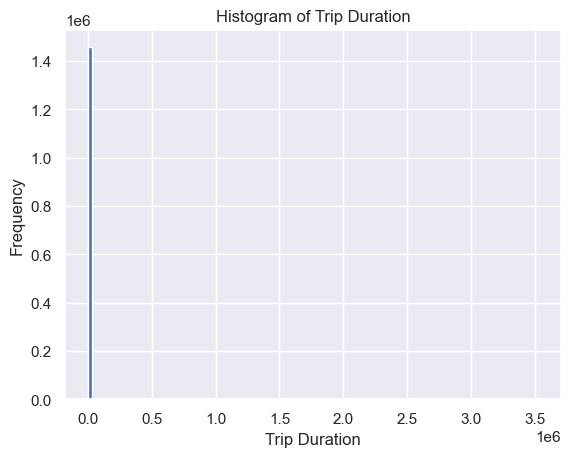

In [108]:
plt.hist(train['trip_duration'], bins=100)
plt.title('Histogram of Trip Duration')
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')
plt.show()

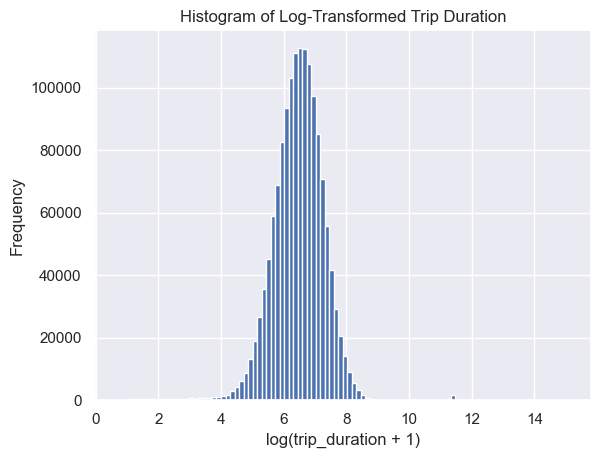

In [109]:
train['log_trip_duration'] = np.log1p(train['trip_duration'])

plt.hist(train['log_trip_duration'], bins=100)
plt.xlabel('log(trip_duration + 1)')
plt.ylabel('Frequency')
plt.title('Histogram of Log-Transformed Trip Duration')
plt.show()


**Question**: What can be said about target variable based on this histogram?

From the histogram - we can tell that the target variable is skewed with all trip durations being on the lower end of the spectrum. The data is therefor not normally distributed. Until we apply the log transform to the data which showcases a Gaussian distribution. It also showcases that the majority of of the data points are found near the middle, so mainly around 7-18 mins long. 

In the competition RMSLE is used as a quality metric:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{N}\sum_{i=1}^{N} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Question**: How do you think, why the organizers used RMSLE and not RMSE?

I think the organizers used the RMSLE metric here because we are going to be using the log of the trip duration as the target variable to prevent skewness in the data and keep the values in a reasonable range as it is normally distributed to the log of the target variable. This also helps because for example a 10 minute error on a 1 hour trip is not as bad as a 10 minute error for a 15 minute ride which the $RMSLE$ takes better into account. Would make it more robust to outliers too.

Standard linear regression model in `sklearn` is usually trained by minimizing MSE and not RMSLE. Let's use the following trick: we will predict not the original target, but its logarithm $\hat{y}_i = \log{(y_i + 1)}$. Then the prediction of the original target can be found by $a(x_i) = \exp(\hat{a}(x_i)) - 1$, where $\hat{a}(x_i)$ is prediction from the model that is trained on the modified target $\hat{y}_i$.

So we transform the RMSLE optimization problem to standard MSE optimization. Moreover, taking the logarithm gives us additional useful property. To see it let's add to the training set the column  `log_trip_duration` (use the function `np.log1p`) and plot the histogram of modified target. Delete the column with the old target.

In [110]:
train.drop('trip_duration', axis=1, inplace=True)

In order to start with something, let's compute the metric value for constant prediction:

In [111]:
def rmsle(log1p_y_true, log1p_y_pred): 
    return np.sqrt(np.mean(np.square(log1p_y_true - log1p_y_pred)))

rmsle_best_const = rmsle(train['log_trip_duration'], np.mean(train['log_trip_duration']))
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411509


In [112]:
print(train['pickup_datetime'].min(), train['pickup_datetime'].max())


2016-01-01 00:00:17 2016-06-30 23:59:39


## Part 1. Analyzing `pickup_datetime` (2 pts)

**Task 2 (0.25 pts)**. Let's look at a distribution of number of rides for each day of the year. Plot the dependence between number of rides and day number in a year (for example, you may use `sns.countplot`):

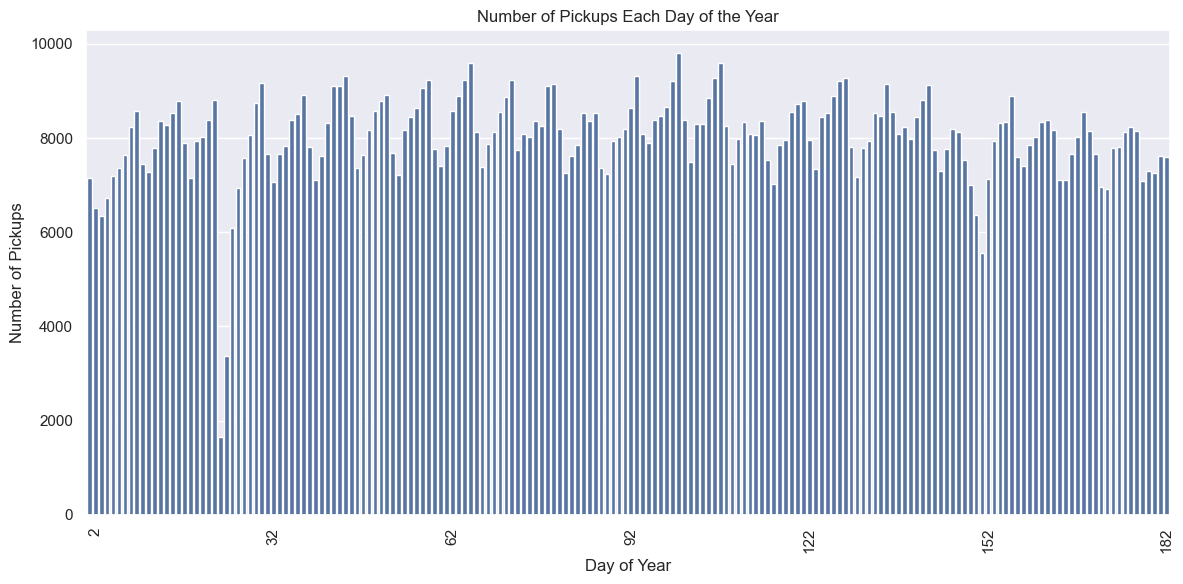

In [113]:
train['day_pickup'] = train['pickup_datetime'].dt.dayofyear
plt.figure(figsize=(12, 6))

sns.countplot(x='day_pickup', data=train)
plt.title('Number of Pickups Each Day of the Year')
plt.xlabel('Day of Year')
plt.ylabel('Number of Pickups')
ticks = np.arange(1, train['day_pickup'].max()+1, 30)
plt.xticks(ticks=ticks, rotation=90)

plt.tight_layout()
plt.show()

**Question**: As you probably noted on the plot there are 2 periods with too small number of rides. Find out what happened in New York City in the corresponding dates.

23rd and 24th day of that year had the fewest number of rides in New York City. Those days had the least number of rides as the USA was hit with one of its deadliest blizzards ever recorded. 

Plot number of rides w.r.t. day of a week and hours of a day (use `sns.relplot`):

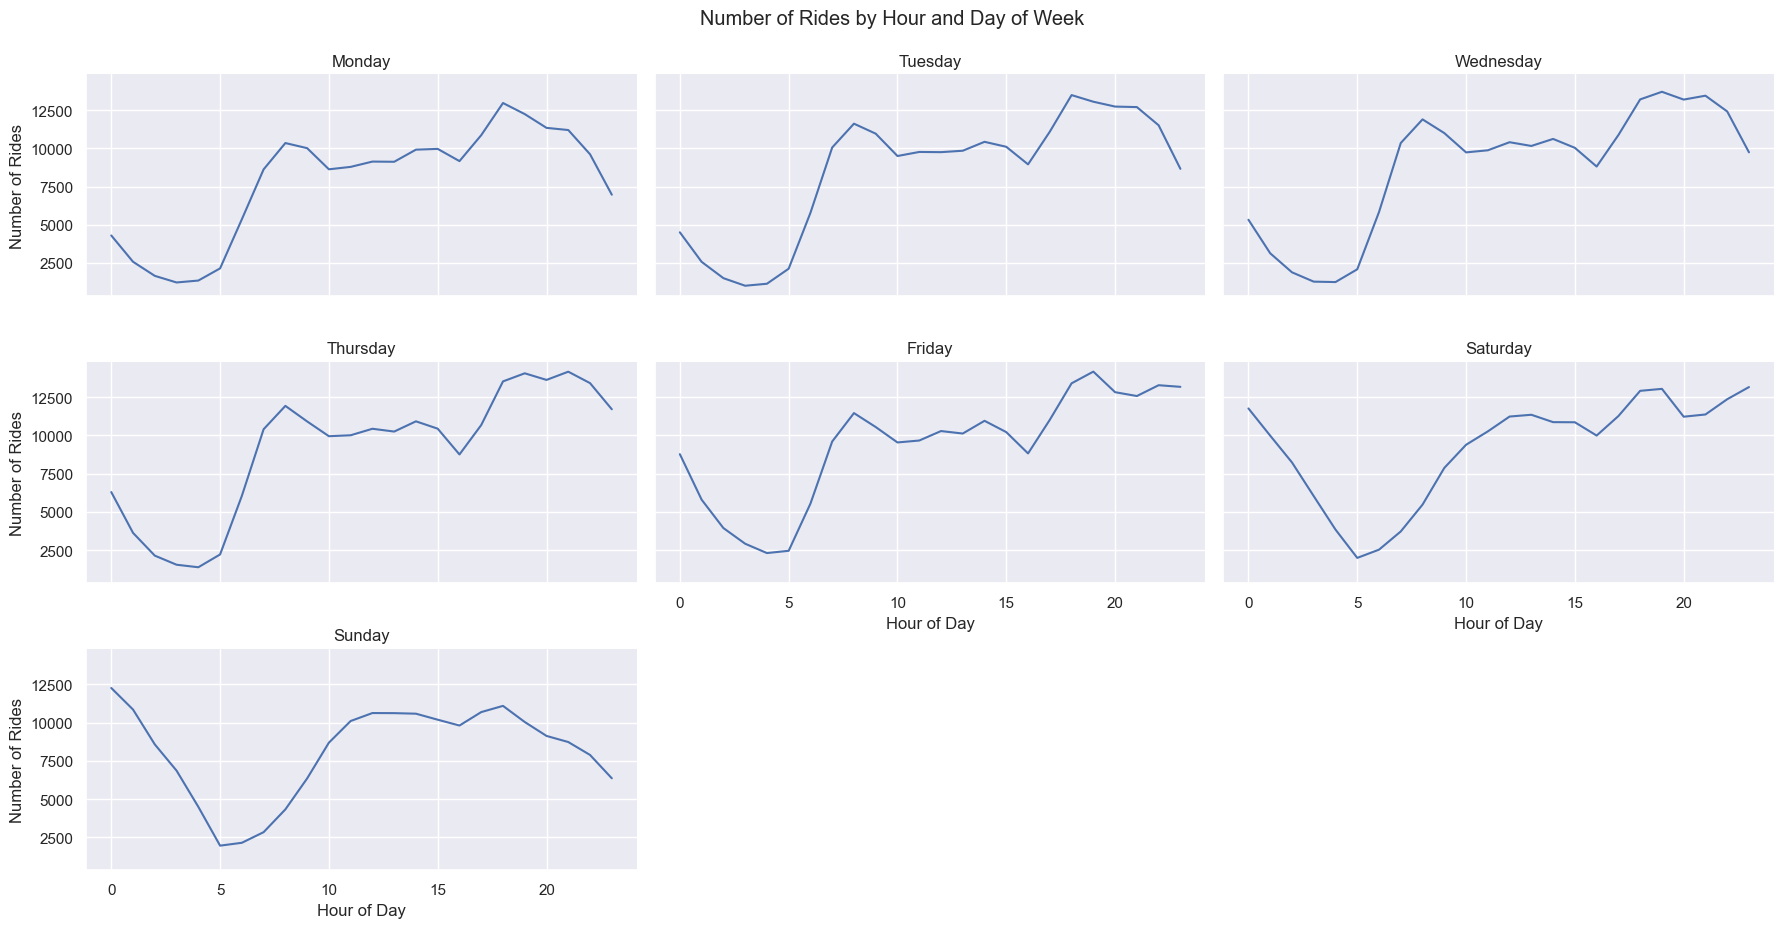

weekday  hour_pickup  ride_count
0       Friday            0        8779
1       Friday            1        5804
2       Friday            2        3949
3       Friday            3        2924
4       Friday            4        2313
..         ...          ...         ...
163  Wednesday           19       13693
164  Wednesday           20       13183
165  Wednesday           21       13438
166  Wednesday           22       12407
167  Wednesday           23        9735

[168 rows x 3 columns]

In [114]:
train['hour_pickup'] = train['pickup_datetime'].dt.hour
train['weekday'] = train['pickup_datetime'].dt.day_name() 

# aggregating the data: count rides per hour and per weekday
ride_counts = train.groupby(['weekday', 'hour_pickup']).size().reset_index(name='ride_count')

# defining the proper weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ride_counts['weekday'] = pd.Categorical(ride_counts['weekday'], categories=weekday_order, ordered=True)


g = sns.relplot(
    data=ride_counts,
    x='hour_pickup',
    y='ride_count',
    kind='line',
    col='weekday',
    col_order=weekday_order,
    col_wrap=3, 
    height=3,
    aspect=2
)

g.set_axis_labels("Hour of Day", "Number of Rides")
g.set_titles("{col_name}")
plt.suptitle("Number of Rides by Hour and Day of Week", y=1.03)
plt.show()
ride_counts

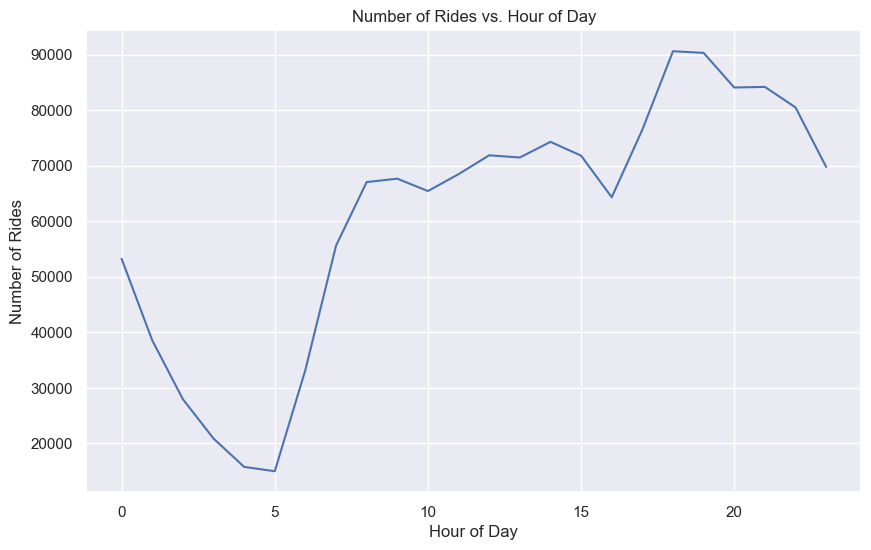

hour_pickup  ride_count
0             0       53248
1             1       38571
2             2       27972
3             3       20895
4             4       15792
5             5       15002
6             6       33248
7             7       55600
8             8       67053
9             9       67663
10           10       65437
11           11       68476
12           12       71873
13           13       71473
14           14       74292
15           15       71811
16           16       64313
17           17       76483
18           18       90600
19           19       90308
20           20       84072
21           21       84185
22           22       80492
23           23       69785

In [115]:
# Extract the hour of pickup
train['hour_pickup'] = train['pickup_datetime'].dt.hour

# Aggregate the number of rides per hour
ride_counts = train.groupby('hour_pickup').size().reset_index(name='ride_count')

# Plot the aggregated data using a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=ride_counts, x='hour_pickup', y='ride_count')
plt.title('Number of Rides vs. Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.show()
ride_counts


**Task 3 (0.5 pts)**. Plot number of rides w.r.t. hours of a day for different months (different curves corresponding to different months should be given in different colors; use `hue` in `sns.relplot`). In analogous way plot number of rides w.r.t. hours of a day for different days in a week.

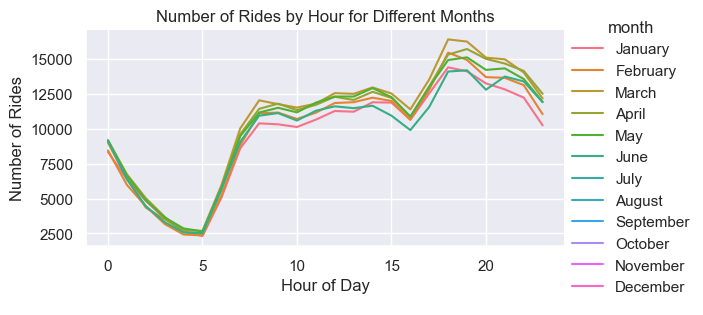

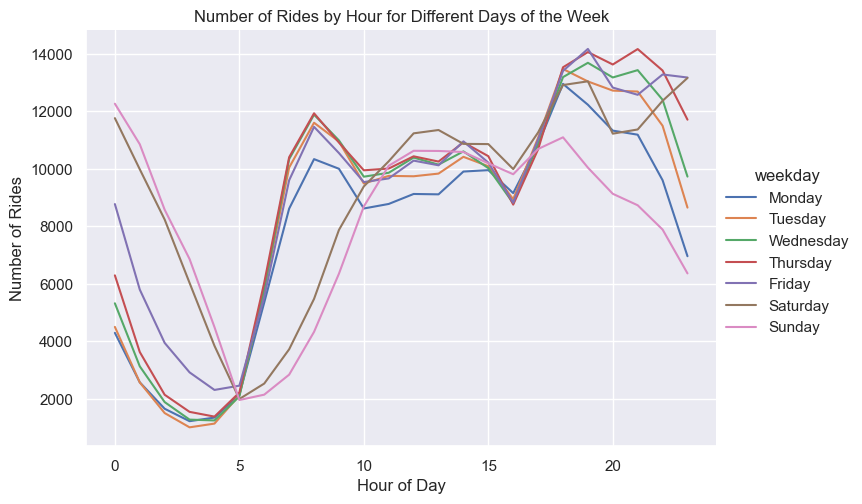

In [116]:
train['hour_pickup'] = train['pickup_datetime'].dt.hour
train['weekday'] = train['pickup_datetime'].dt.day_name() 
train['month'] = train['pickup_datetime'].dt.month_name()

# aggregating the data: count rides per hour and per weekday
ride_counts_month = train.groupby(['month', 'hour_pickup']).size().reset_index(name='ride_count')

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
ride_counts_month['month'] = pd.Categorical(ride_counts_month['month'], 
                                             categories=month_order, ordered=True)
sns.relplot(
    data=ride_counts_month,
    x='hour_pickup',
    y='ride_count',
    kind='line',
    col_order=month_order,
    hue='month',
    height=3,
    aspect=2
)

plt.title('Number of Rides by Hour for Different Months')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.show()

# ------------------------------------------------- Plot 2 

ride_counts_weekday = train.groupby(['weekday', 'hour_pickup']).size().reset_index(name='ride_count')

# Define the order for weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ride_counts_weekday['weekday'] = pd.Categorical(ride_counts_weekday['weekday'], 
                                                 categories=weekday_order, ordered=True)

# Plot using relplot with hue corresponding to the weekday
sns.relplot(
    data=ride_counts_weekday,
    x='hour_pickup',
    y='ride_count',
    hue='weekday',
    kind='line',
    height=5,
    aspect=1.5
)
plt.title('Number of Rides by Hour for Different Days of the Week')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.show()
    

**Question**: What conclusions can be made based on the constructed plots? Are some days of a week differ somehow from the others? And what about hours of a day? What are the reasons for it?

The conclusions that can clearly be made is that in general for all months of the year - the number of rides follows the same pattern - same thing with the number of rides vs the hour of different days of the week. They all show the same pattern. The number of rides is generally at it lowest past 12 am and until 5 am. 

For the weekdays. Monday-Friday there seems to be a peak in the number of rides at around 8 am. This makes sense as it is most likely caused by the teenagers who call a ride to school in the morning or adults who do not own a car so that they can go to work. Sundays and Saturdays do not have this peak since there is no school/work. All days peak at around 18:00. With Friday having the highest number of rides at this time out of all the different days of the week. This could be due to not only the fact that employees will be returning from work and students from school but also because some maybe going out for dinner since it is the start of the weekend. Sunday generally has the lowest number of rides. This could be due to the fact that it is the day of the week that people are most likely to be at home relaxing. After 20:00, the number of rides decreases once more as people are at home sleeping mostly. Saturday actually peaks at around 23:00 which goes to show that people are staying up late and going out since its the weekend. There is a small dip in the number of ride at circa 16:00 which could be due to the fact that there is limited availability of taxis because that is usually rush hour time and people prefer to avoid the traffic by using other forms of transport.  


 All of these conclusions make sense following the data visualization techniques that were used here. 

The difference between the different months of the year and the number of rides by hour is very minimal. With the biggest peak once again in the range of 18:00 in March. 

**Task 4 (0.5 pts)**. Split dataset into train and train_data_clean part in a ratio 7:3 (use `train_test_split` from `sklearn`). Using the train part plot the dependence between mean logarithm of ride duration w.r.t. day of a week. Then do the same for hour of a day and day number of a year.

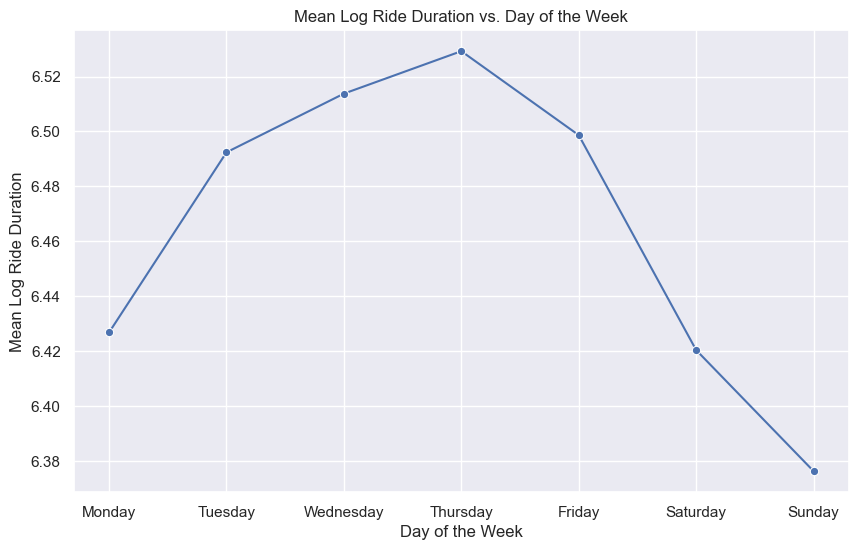

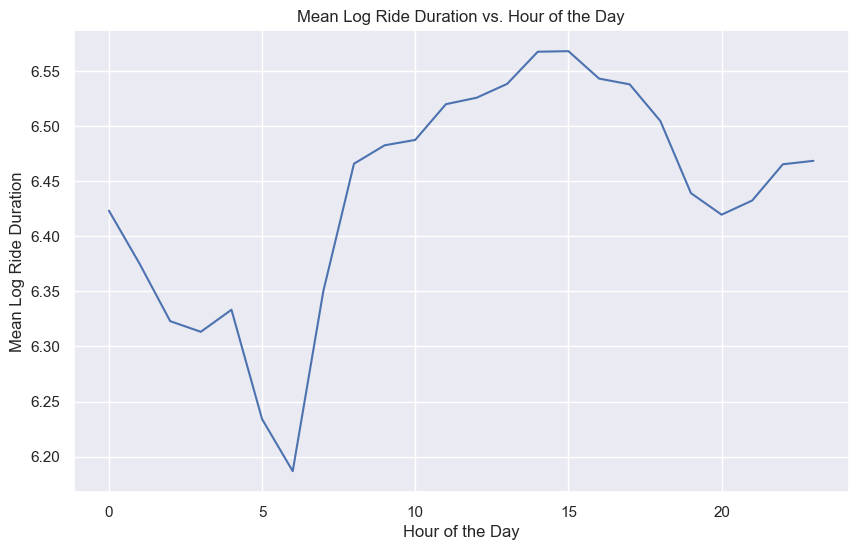

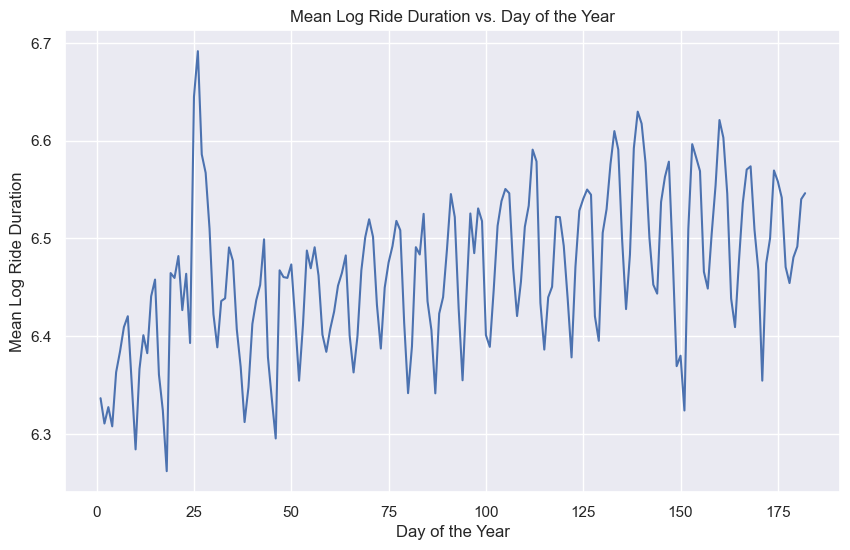

In [ ]:
from sklearn.model_selection import train_test_split

train_data_clean, test_data = train_test_split(train, test_size=0.3, random_state=42)

# Extract day of week, hour of day, and day of year
train_data_clean['weekday'] = train_data_clean['pickup_datetime'].dt.day_name()
train_data_clean['hour'] = train_data_clean['pickup_datetime'].dt.hour
train_data_clean['day_of_year'] = train_data_clean['pickup_datetime'].dt.dayofyear

# ---------------------------------------------------
# 1. Mean Log Ride Duration vs. Day of the Week
# ---------------------------------------------------
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group by weekday and compute mean log_trip_duration
weekday_means = train_data_clean.groupby('weekday')['log_trip_duration'].mean().reset_index()

# Ensure the weekday order is correct
weekday_means['weekday'] = pd.Categorical(weekday_means['weekday'],
                                           categories=weekday_order,
                                           ordered=True)

plt.figure(figsize=(10, 6))
sns.lineplot(data=weekday_means.sort_values('weekday'), x='weekday', y='log_trip_duration', sort=False, marker ='o')
plt.title("Mean Log Ride Duration vs. Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Mean Log Ride Duration")
plt.show()

# ---------------------------------------------------
# 2. Mean Log Ride Duration vs. Hour of the Day
# ---------------------------------------------------
hour_means = train_data_clean.groupby('hour')['log_trip_duration'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=hour_means, x='hour', y='log_trip_duration')
plt.title("Mean Log Ride Duration vs. Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Log Ride Duration")
plt.show()

# ---------------------------------------------------
# 3. Mean Log Ride Duration vs. Day number of the Year
# ---------------------------------------------------
day_of_year_means = train_data_clean.groupby('day_of_year')['log_trip_duration'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=day_of_year_means, x='day_of_year', y='log_trip_duration')
plt.title("Mean Log Ride Duration vs. Day of the Year")
plt.xlabel("Day of the Year")
plt.ylabel("Mean Log Ride Duration")
plt.show()


**Question**: Are the plots of target variable w.r.t. day of a week and hour of a day similar to the analogous plots for number of rides? Why? What is happening to the mean target in those two anomalous periods? Why is that happening? Do you see any trend on a plot of dependence between `log_trip_duration` and day number of a year?

From what I can see yes they are largely similar and have the same pattern. For example when comparing the mean log duration vs hour of the day it looks very similar to the plot of the number of rides vs hours of the day - there are only very subtle differences. And this makes sense because they are showing the same underlying patterns behind the data, so if the number of rides increases that usually means more traffic and the duration of trips is usually longer - a positive correlation. 

The 2 anomalous periods that I see are: one is around the 26th day of the year where the mean log ride Duration is unusually high. Since we already mentioned that this day saw a blizzard - it could mean it was much higher because although trips were less; the rides were much longer due to the snow and the $logarithm$ takes this into account. The other anomalous period is around the 150th day of the year where the mean log ride duration is unusually low. This could be because of the summer heat and people only needing short suburban rides.

When comparing `log_trip_duration`and day number of a year I see a general positive correlation - so the further in to the year we are the longer the rides are with obvious fluctuations in the middle. Which makes sense - there likely means there was increased tourism in the city as the summer rolled in.

Add the following features to the dataset based on `pickup_datetime`:
1. Day of a week
2. Month
3. Hour
4. Is the period anomalous (two binary features corresponding to two anomalous periods)
5. Day number in a year

In [ ]:
train_data_clean['day_of_week'] = train_data_clean['pickup_datetime'].dt.day_name()
train_data_clean['hour'] = train_data_clean['pickup_datetime'].dt.hour
train_data_clean['month'] = train_data_clean['pickup_datetime'].dt.month_name()

train_data_clean['day_of_year'] = train_data_clean['pickup_datetime'].dt.dayofyear
train_data_clean['anomalous_period1'] = train_data_clean['day_of_year'].between(23, 28).astype(int)
train_data_clean['anomalous_period2'] = train_data_clean['day_of_year'].between(150,152).astype(int)


So, we have created a set of features.

**Question**: Which of the features _should be considered in this task_ as cathegorical, and which - as numerical? Why?

Categorical: day of week and month of year, anomalous_period1 and 2 since there is only a discrete number of each of these features. 

Numerical: hour, day_of_year,since these features are continuous and can take any value within a certain range.

**Task 5 (0.75 pts)**. Fit `Ridge`-regression with default parameters, encoding all cathegorical features using `OneHotEncoder`. Numerical features should be normalized using `StandardScaler`. Use only features that were created in this part of the assignment.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge


categorical_features = ['day_of_week', 'month', 'anomalous_period1', 'anomalous_period2']
numerical_features = ['hour', 'day_of_year']

x_num = train_data_clean[numerical_features]
x_cat = train_data_clean[categorical_features]

encoder = OneHotEncoder(drop='first')
x_cat_encoded = encoder.fit_transform(x_cat)

scaler = StandardScaler()
x_num_scaled = scaler.fit_transform(x_num)

X_combined = np.concatenate([x_num_scaled, x_cat_encoded.toarray()], axis=1)
y = train_data_clean['log_trip_duration']


ridge = Ridge() 
ridge.fit(X_combined, y)


Ridge()

## Part 2. Analyzing coordinates (3 pts)
To the current moment we have already dived into the data about pickup start date and time. Now let's look at the information about geographical coordinates of trip start and finish. Here you can find a function that plots points of trip start and finish on a real map. Examples for its usage you may find below. Please pay attention that only a small portion of data should be given to this function. Otherwise everything would work very slowly.

In [120]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [ ]:
show_circles_on_map(train_data_clean.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [122]:
show_circles_on_map(train.sample(10000), "dropoff_latitude", "dropoff_longitude", "blue")

**Question**: Which points (or point clusters) are differ from others on this map and can be useful for our problem? What are their peculiarities? Why have you chosen them?

We can use the points that are further away for example like the ones at the John F Kennedy airport. The points that are further away are more likely to be the ones that are not in the same location as the other points. We can use the points that are further away to determine the location of the other big cluster of points. 

**Task 6 (0.75 pts)**. Ride time can be computed as a ratio of covered distance to mean speed $t = s / v_{\text{mean}}$. Hence it is quite obvious that one of the most informative feature here for target prediction would be the covered distance. We can't compute the exact covered distance for taxi ride but we can approximate it using distance between start and finish coordinate points. Here we may use `haversine` function. Compute the approximate distance for all taxi rides and add this information to the column `haversine`.

In [ ]:
from haversine import haversine


train_data_clean['haversine'] = train_data_clean.apply(
    lambda row: haversine(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ),
    axis=1
)

We are predicting logarithm of trip duration and want a linear dependence between features and target variable (because we fit linear predictors). Hence we need to take a logarithm for the covered distance: $\log t = \log s - \log{v_{\text{mean}}}$. Add logarithm of the feature `haversine` to a separate column `log_haversine`:

In [ ]:
train_data_clean['log_haversine'] = np.log1p(train_data_clean['haversine'])

Let's see that logarithm of the distance has better correlation with targets and the distance itself:

In [ ]:
assert train_data_clean['log_haversine'].corr(train_data_clean['log_trip_duration']) > train_data_clean['haversine'].corr(train_data_clean['log_trip_duration'])

In [ ]:
print(train_data_clean['haversine'].describe())
print(train_data_clean['log_trip_duration'].describe())

count    1.021050e+06
mean     3.443978e+00
std      4.361110e+00
min      0.000000e+00
25%      1.231738e+00
50%      2.095421e+00
75%      3.879413e+00
max      1.240910e+03
Name: haversine, dtype: float64
count    1.021050e+06
mean     6.467067e+00
std      7.960733e-01
min      6.931472e-01
25%      5.986452e+00
50%      6.498282e+00
75%      6.981006e+00
max      1.507575e+01
Name: log_trip_duration, dtype: float64


**Task 7 (0.75 pts)**. Let's investigate a mean taxi speed. Estimate the mean speed for each object from the training set by dividing `haversine` on `trip_duration`, and plot the histogram of this distribution.

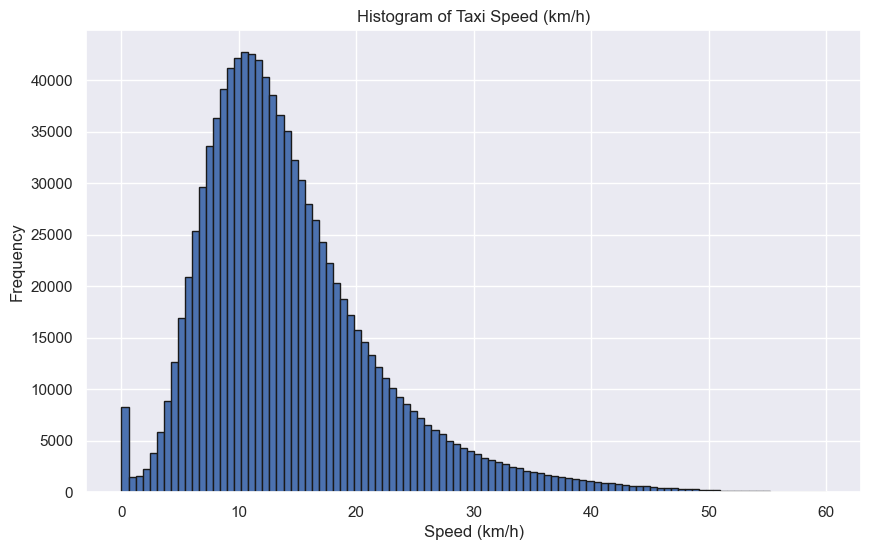

In [ ]:
# Now compute the mean speed (in meters per second)
train_data_clean['speed']=train_data_clean['haversine']/(train_data_clean['log_trip_duration'].apply(np.expm1)/3600)

plt.figure(figsize=(10, 6))
plt.hist(train_data_clean['speed'], bins=100, edgecolor='k', range=[0, 60])
plt.title('Histogram of Taxi Speed (km/h)')
plt.xlabel('Speed (km/h)')
plt.ylabel('Frequency')
plt.show()

As you may note for some objects we get very big speed values. Plot the speed histogram only for objects with reasonable speed values (for example, we may exclude objects greater than some quantile):

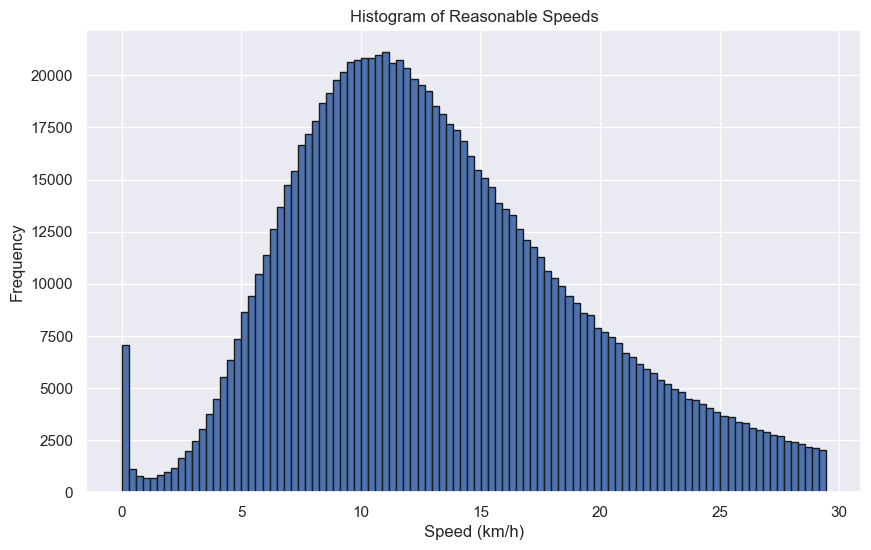

In [ ]:
upper_threshold = train_data_clean['speed'].quantile(0.95) # only take the 95th percentile of speeds

reasonable_speeds = train_data_clean[train_data_clean['speed'] < upper_threshold]

plt.figure(figsize=(10, 6))
plt.hist(reasonable_speeds['speed'], bins=100, edgecolor='k')
plt.title('Histogram of Reasonable Speeds')
plt.xlabel('Speed (km/h)')
plt.ylabel('Frequency')
plt.show()

For each pair (day of a week, hour of a day) compute speed median. Using `sns.heatmap` make a plot with axes day of a week and hour of a day and values speed median.

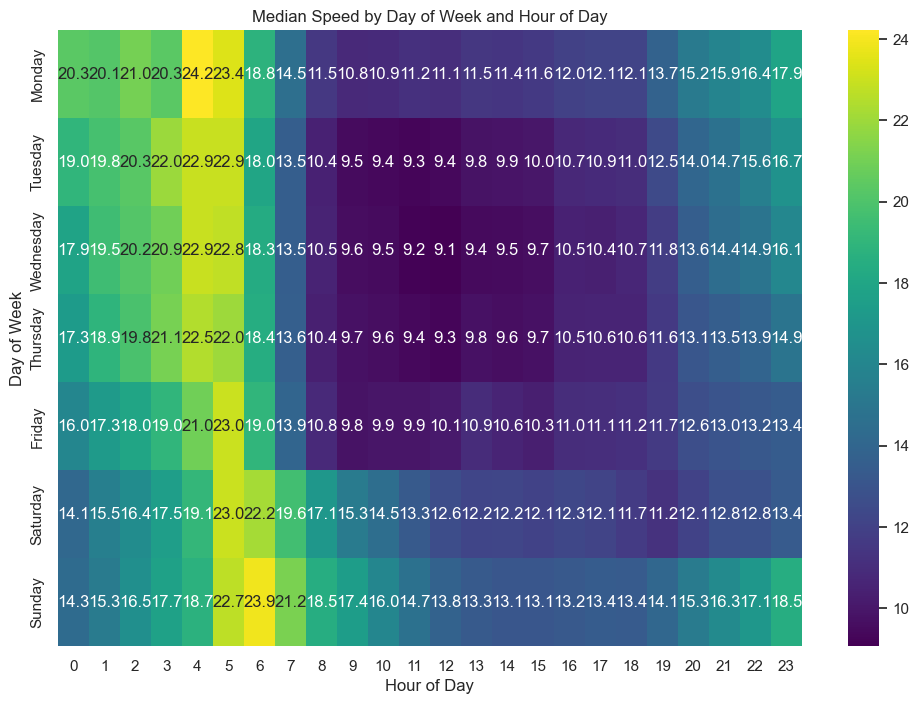

In [ ]:
speed_median = train_data_clean.groupby(['day_of_week', 'hour'])['speed'].median().reset_index()

speed_median_pivot = speed_median.pivot(index='day_of_week', columns='hour', values='speed') # heatmap needs a 2d matrix 


weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
speed_median_pivot = speed_median_pivot.reindex(weekday_order)

plt.figure(figsize=(12, 8))
sns.heatmap(speed_median_pivot, annot=True, fmt=".1f", cmap="viridis")
plt.title("Median Speed by Day of Week and Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

train_data_clean = train_data_clean.drop('speed', axis=1)

Do not forget to delete the column with speed from the data!

**Question**: Why speed value can't be used for training?

Since speed is calculated using the target variable - this is going to lead to data leakage as the model would be able to reverse engineer the target variable from the speed. We are trying to predict the trip duration so we would not be able to calculate the speed when deploying the model. 

**Question**: Look at the plot and say at what moments the speed is minimal; maximal.

Create features ''trip occurs in traffic jam'' and ''trip occurs on free roads'' (certainly it should not depend on the speed!):

In [ ]:
train_data_clean['day_of_week'] = train_data_clean['pickup_datetime'].dt.day_name()
train_data_clean['hour'] = train_data_clean['pickup_datetime'].dt.hour

rush_hours = (train_data_clean['hour'] >= 8) & (train_data_clean['hour'] < 16)
weekday = train_data_clean['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])


train_data_clean['traffic_jam'] = ((weekday) & (rush_hours)).astype(int)

# inverse is trip in free roads
train_data_clean['free_roads'] = (1 - train_data_clean['traffic_jam']).astype(int)

Speed reached its max of 24.2 Km/h at 4 AM on Monday - most likely because the roads are empty at this time. Whereas the minimal speed value is 9.1 Km/h on Wednesday midday which is likely due to the heavy traffic at the time. 

**Task 8 (0.25 pts)**. For each of determined specific cluster of start/finish points add to the dataset two features: 
- the trip was started in the specific point
- the trip was ended in the specific point

How do you think, why these features can be useful?

In [ ]:
def is_jfk(latitude, longitude):
    return (latitude >= 40.0 and latitude <= 40.66) and (longitude >= -73.81 and longitude <= -73.77)

train_data_clean['pickup_jfk'] = train_data_clean.apply(
    lambda row: int(is_jfk(row['pickup_latitude'], row['pickup_longitude'])),
    axis=1
)

train_data_clean['dropoff_jfk'] = train_data_clean.apply(
    lambda row: int(is_jfk(row['dropoff_latitude'], row['dropoff_longitude'])),
    axis=1
)

For each of the constructed features make a boxplot (`sns.boxplot`) for distribution of logarithm of trip duration

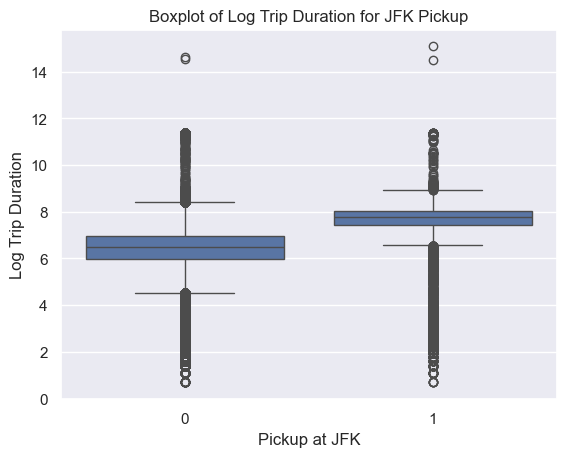

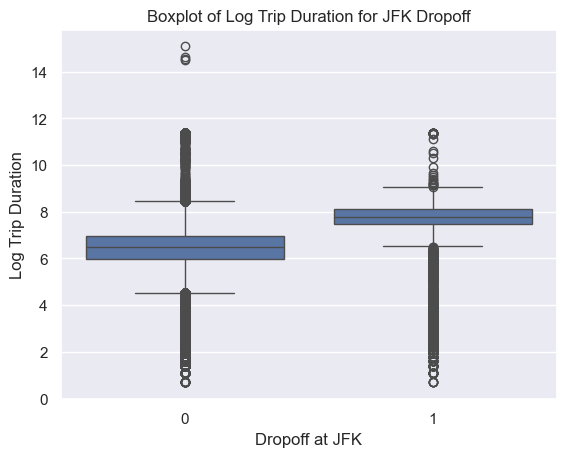

In [ ]:
sns.boxplot(x='pickup_jfk', y='log_trip_duration', data=train_data_clean)
plt.title('Boxplot of Log Trip Duration for JFK Pickup')
plt.xlabel('Pickup at JFK')
plt.ylabel('Log Trip Duration')
plt.show()

sns.boxplot(x='dropoff_jfk', y='log_trip_duration', data=train_data_clean)
plt.title('Boxplot of Log Trip Duration for JFK Dropoff')
plt.xlabel('Dropoff at JFK')
plt.ylabel('Log Trip Duration')
plt.show()

**Question**: using these plots are the constructed features good?

Yes, I believe they are definitely good as the median of the drop off / pick up times = 1 i.e. they start or end at the airport, is much higher than that for other trips. This can be very significant to the training of the model as it can establish a new relationship. The interquartile range is also smaller for these trips, indicating a lower variability. 

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Task 9 (1 pts)**. To the current moment we almost didn't used the coordinates themselves. There are several reasons for this. First, the coordinates longtitute and latitude should be considered together and, second, the dependence between target and coordinates is not linear. In order to use coordinates somehow, we may use the following trick: find a geographic rectangle with the most number of rides (as on the figure) and then split this rectangle into ceparate cells. Let's assign a separate number to each of the cell and -1 to out-of-cell coordinates.

Write a transformer that first split the region into cells and then create two features: cell id for trip start and cell id for trip end. Choose number of rows and columns by yourself.

Please pay attention that all computations should be vectorized. The transformer should not modify the given dataset inplace, and all necessary statistics should be computed using the training set in `fit` procedure.

In [158]:
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently
    
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pickup_lat='pickup_latitude', pickup_lon='pickup_longitude',
                 dropoff_lat='dropoff_latitude', dropoff_lon='dropoff_longitude',
                 nrows=10, ncols=10):
        
        self.pickup_lat = pickup_lat
        self.pickup_lon = pickup_lon
        self.dropoff_lat = dropoff_lat
        self.dropoff_lon = dropoff_lon
        self.nrows = nrows
        self.ncols = ncols
        
        self.lat_edges_ = None
        self.lon_edges_ = None
    
    def show_map(self):
        # you may want to visualize cells
        pass
    
    def fit(self, X, y=None):
        
        pickup_lat_vals = X[self.pickup_lat].values
        pickup_lon_vals = X[self.pickup_lon].values
        dropoff_lat_vals = X[self.dropoff_lat].values
        dropoff_lon_vals = X[self.dropoff_lon].values

       # boundary of box 
        lat_min = np.min(np.concatenate([pickup_lat_vals, dropoff_lat_vals]))
        lat_max = np.max(np.concatenate([pickup_lat_vals, dropoff_lat_vals]))
        lon_min = np.min(np.concatenate([pickup_lon_vals, dropoff_lon_vals]))
        lon_max = np.max(np.concatenate([pickup_lon_vals, dropoff_lon_vals]))

       # equally spaced edges 
        self.lat_edges_ = np.linspace(lat_min, lat_max, self.nrows + 1)
        self.lon_edges_ = np.linspace(lon_min, lon_max, self.ncols + 1)

        return self

    def transform(self, X, y=None):
        
        X_ = X.copy()
        
        pickup_lat_bin = np.digitize(X_[self.pickup_lat].values, self.lat_edges_) - 1
        pickup_lon_bin = np.digitize(X_[self.pickup_lon].values, self.lon_edges_) - 1

    
        dropoff_lat_bin = np.digitize(X_[self.dropoff_lat].values, self.lat_edges_) - 1
        dropoff_lon_bin = np.digitize(X_[self.dropoff_lon].values, self.lon_edges_) - 1

        pickup_cell_id = self._compute_cell_id(pickup_lat_bin, pickup_lon_bin)
        dropoff_cell_id = self._compute_cell_id(dropoff_lat_bin, dropoff_lon_bin)

        X_['cell_id_pickup'] = pickup_cell_id
        X_['cell_id_dropoff'] = dropoff_cell_id

        return X_
# helper function 
    def _compute_cell_id(self, lat_bin, lon_bin):

        in_bounds = (
            (lat_bin >= 0) & (lat_bin < self.nrows) &
            (lon_bin >= 0) & (lon_bin < self.ncols)
        )

        cell_id = lat_bin * self.ncols + lon_bin

        cell_id[~in_bounds] = -1

        return cell_id


**Task 10 (0.25 pts)**. Fit `Ridge`-regression with default parameters using features we have constructed to the current moment. Use one-hot-encoding for cathegorical features and scaling/normalization for numerical features.

In [ ]:
from sklearn.model_selection import cross_val_score
scaler = StandardScaler()
numerical_features = ['hour', 'day_of_year', 'haversine']
numerical_features_scaled = scaler.fit_transform(train_data_clean[numerical_features])

categorical_features = ['day_of_week', 'month', 'anomalous_period1', 'anomalous_period2', 'traffic_jam', 'free_roads', 'pickup_jfk', 'dropoff_jfk']
encoder = OneHotEncoder(drop='first')
categorical_features_scaled = encoder.fit_transform(train_data_clean[categorical_features])
X_combined = np.concatenate([numerical_features_scaled, categorical_features_scaled.toarray()], axis=1)
y = train_data_clean['log_trip_duration']

ridge = Ridge()

scores = cross_val_score(ridge, X_combined, y, cv=5, scoring='neg_mean_squared_error')
rmse = np.sqrt(-scores)
print("RMSE using other features including hour, day of year, haversine etc:", rmse.mean())

RMSE using other features including hour, day of year, haversine etc: 0.6421402576966486


## Part 3. Analyzing the remaining features (1 pts)

**Task 11 (0.75 pts)**. We have three features that were not analyzed to the current moment: `vendor_id`, `passenger_count` and `store_and_fwd_flag`.

**Question**: Think on why each of these features may be useful.

So as for `vendor_id` it could be that certain vendors dominate in a specific geographical area and these vendors may operate slighlty differently to each other due to intra-company protocols and rules and regulations which could affect the trip duration 

whereas for `passenger_count` - a higher passenger count could mean a different type of service being offered by the vendor, or a different type of vehicle being used. This could have an affect on the trip duration. 

and finally for `store_and_fwd_flag` - this feature likely stands for data that was stored and collected but only forwarded later due to connectivity issues. This could also affect the target variable as there may be data leakage some faulty data that was not properly recorded.

Count the number of unique values for each of these features:

In [ ]:
uni_vendors = train_data_clean['vendor_id'].nunique()
uni_passengers = train_data_clean['passenger_count'].nunique()
uni_store_and_fwd_flag = train_data_clean['store_and_fwd_flag'].nunique()

print(uni_vendors, uni_passengers, uni_store_and_fwd_flag)

2 10 2


Construct boxplots for distributions of log trip duration and each of these features.

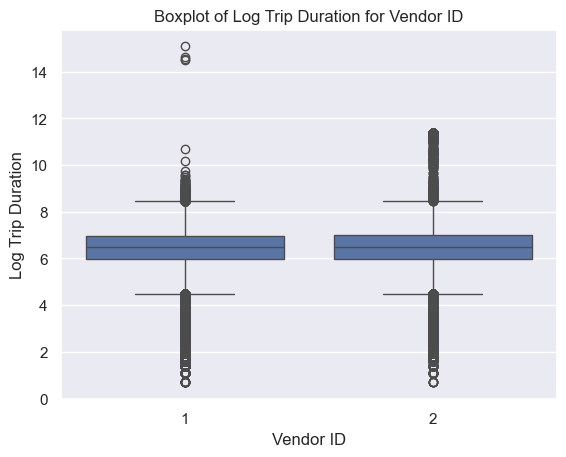

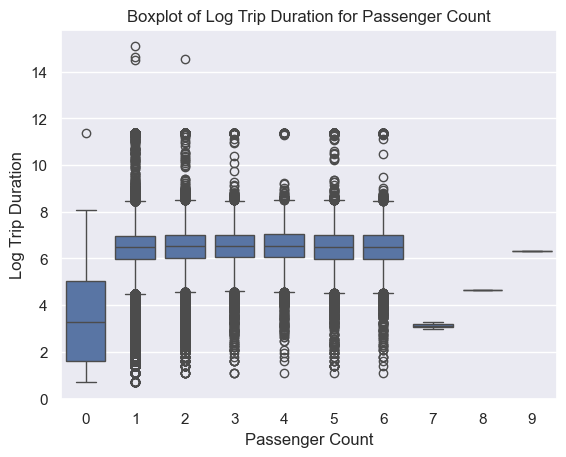

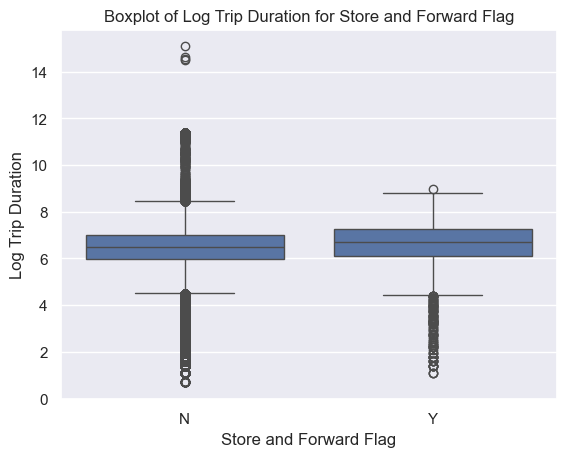

In [ ]:
sns.boxplot(x='vendor_id', y='log_trip_duration', data=train_data_clean)
plt.title('Boxplot of Log Trip Duration for Vendor ID')
plt.xlabel('Vendor ID')
plt.ylabel('Log Trip Duration')
plt.show()

# ---------------------------------------------------
sns.boxplot(x='passenger_count', y='log_trip_duration', data=train_data_clean)
plt.title('Boxplot of Log Trip Duration for Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Log Trip Duration')
plt.show()

#---------------------------------------------------
sns.boxplot(x='store_and_fwd_flag', y='log_trip_duration', data=train_data_clean)
plt.title('Boxplot of Log Trip Duration for Store and Forward Flag')
plt.xlabel('Store and Forward Flag')
plt.ylabel('Log Trip Duration')
plt.show()

Transform the features `vendor_id` and `store_and_fwd_flag` into values $\{0;1\}$

In [ ]:
train_data_clean['vendor_id'] = (train_data_clean['vendor_id'] == 2).astype(int)
train_data_clean['store_and_fwd_flag'] = (train_data_clean['store_and_fwd_flag'] == 'Y').astype(int)

**Question**: Based on the plots above what is your opinion on the prediction quality of these features?

Honestly, I can safely say that both the `store_and_fwd_flag`and the `vendor_id` can be ommitted from the training of the model as the positive and negative versions of each are pretty much identical with very small difference in the median of both types of data vs the log of the duration time. As for `passenger_count` I would keep it in the features required to train the model as the extreme cases could be used to train the model if handled correctly. With the 0 passenger rides most likely being data artifacts or 'unregistered' rides. Passenger count of 1-4 is mainly the same exact number and so won't be a big factor. 

**Task 12 (0.25 pts)**. Check your considerations by training model on these threee features as well. Train `Ridge`-regression with standard parameters. Encode cathegorical features with one-hot-encoding and normalize the numerical ones.

In [ ]:
from sklearn.model_selection import cross_val_score

scaler = StandardScaler()
numerical_features = ['passenger_count']
numerical_features_scaled = scaler.fit_transform(train_data_clean[numerical_features])

categorical_features = ['vendor_id', 'store_and_fwd_flag']
encoder = OneHotEncoder(drop='first')
categorical_features_scaled = encoder.fit_transform(train_data_clean[categorical_features])
X_combined = np.concatenate([numerical_features_scaled, categorical_features_scaled.toarray()], axis=1)
y = train_data_clean['log_trip_duration']

ridge = Ridge()

scores = cross_val_score(ridge, X_combined, y, cv=5, scoring='neg_mean_squared_error')
rmse = np.sqrt(-scores)
print("RMSE using only vendor_id, passenger_count, and store_and_fwd_flag:", rmse.mean())

RMSE using only vendor_id, passenger_count, and store_and_fwd_flag: 0.7957137926093417


If the features do not give any sufficient impact to the prediction quality then delete them from the data.

The error actually went up with these features involved so will definitely be deleted. 

In [ ]:
train_data_clean = train_data_clean.drop(['vendor_id', 'passenger_count', 'store_and_fwd_flag'], axis=1)

## Part 4. Improving the model (3 pts)

**Task 13 (1 pts)**. In the training data we have non-typical objects (outliers): objects with anomalous small trip duration, with very high covered distance or big remainders of the regression model. In this task the goal is to exclude such objects from the training set. For this reason plot histograms of mentioned values, choose outlier objects and exclude them from the training set.

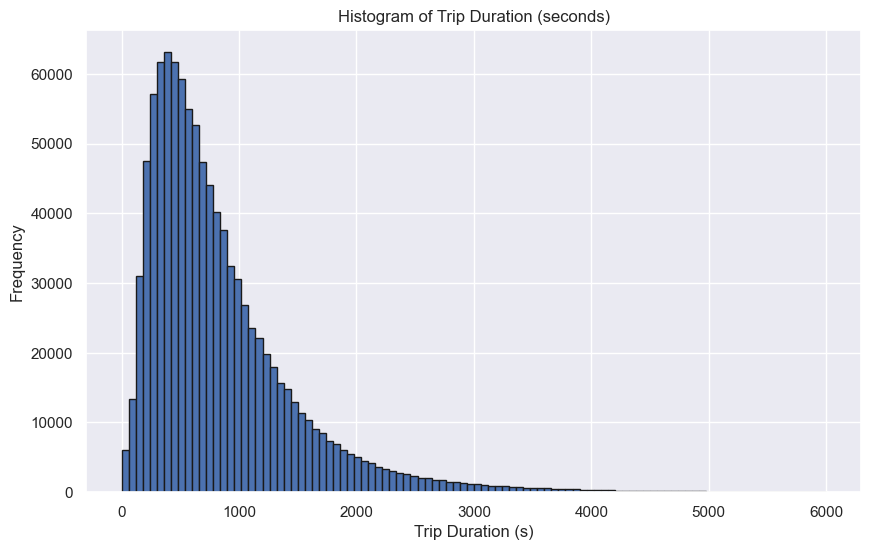

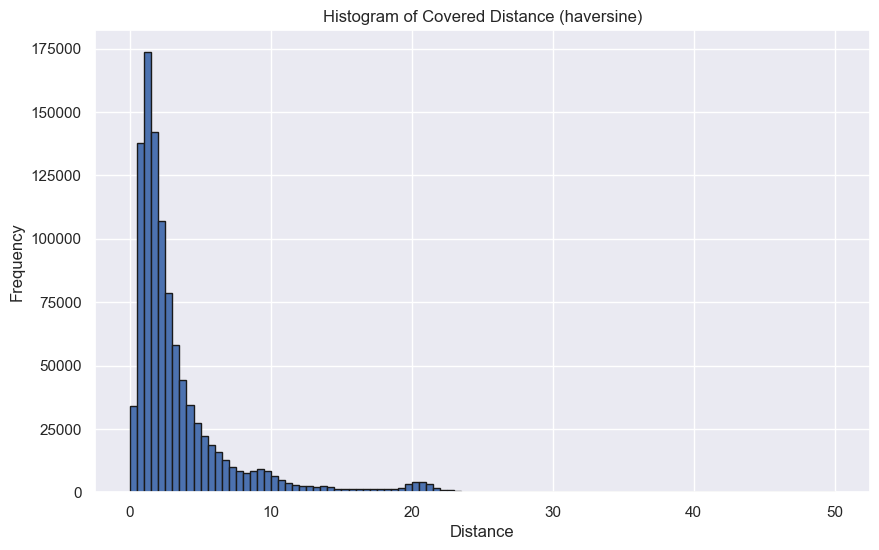

Original data shape: (1021050, 22)
Filtered data shape: (966534, 22)


In [ ]:

trip_duration_sec = np.expm1(train_data_clean['log_trip_duration'])

plt.figure(figsize=(10, 6))
plt.hist(trip_duration_sec, bins=100, edgecolor='k', range=[0, 6000])
plt.title('Histogram of Trip Duration (seconds)')
plt.xlabel('Trip Duration (s)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(train_data_clean['haversine'], bins=100, edgecolor='k', range=[0, 50])
plt.title('Histogram of Covered Distance (haversine)')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

duration_low_threshold = 10
duration_high_threshold = np.percentile(trip_duration_sec, 96)

# For covered distance, choose the 99th percentile as the upper threshold:
distance_threshold = train_data_clean['haversine'].quantile(0.97)

condition = (
    (train_data_clean['log_trip_duration'] > np.log(duration_low_threshold)) &
    (train_data_clean['log_trip_duration'] < np.log(duration_high_threshold)) &
    (train_data_clean['haversine'] < distance_threshold)
)

train_data_clean = train_data_clean[condition].copy()

print("Original data shape:", train_data_clean.shape)
print("Filtered data shape:", train_data_clean.shape)

Currently we have many cathegorical features. Some cathegories are very rare and contain only few objects. The presence of such rare cathegories may lead to model overfitting. For each of the presented cathegorical features find rare cathegories (if there are any) and unite them into one bigger cathegory.

In [148]:
def merge_rare_categories(series, threshold=0.05):


    freq = series.value_counts(normalize=True)
    
    rare_categories = freq[freq < threshold].index
   
    return series.apply(lambda x: 'rare' if x in rare_categories else x)


categorical_features = ['day_of_week', 'month', 'anomalous_period1', 'anomalous_period2', 
                        'traffic_jam', 'free_roads', 'pickup_jfk', 'dropoff_jfk',]

train_data_clean.dtypes

for col in categorical_features:
    train_data_clean[col] = merge_rare_categories(train_data_clean[col], threshold=0.05)
    
train_data_clean.columns

Index(['id', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'log_trip_duration',
       'day_pickup', 'hour_pickup', 'weekday', 'month', 'hour', 'day_of_year',
       'day_of_week', 'anomalous_period1', 'anomalous_period2', 'haversine',
       'log_haversine', 'traffic_jam', 'free_roads', 'pickup_jfk',
       'dropoff_jfk'],
      dtype='object')

In [151]:
from sklearn.model_selection import cross_val_score
scaler = StandardScaler()
numerical_features = ['hour', 'day_of_year', 'haversine', 'log_haversine', ]
numerical_features_scaled = scaler.fit_transform(train_data_clean[numerical_features])

categorical_features = ['day_of_week', 'month', 'anomalous_period1', 'anomalous_period2', 'traffic_jam', 'free_roads', 'pickup_jfk', 'dropoff_jfk']
encoder = OneHotEncoder(drop='first')
for col in categorical_features:
    train_data_clean[col] = train_data_clean[col].astype(str)
categorical_features_scaled = encoder.fit_transform(train_data_clean[categorical_features])
X_combined = np.concatenate([numerical_features_scaled, categorical_features_scaled.toarray()], axis=1)
y = train_data_clean['log_trip_duration']

ridge = Ridge()

scores = cross_val_score(ridge, X_combined, y, cv=5, scoring='neg_mean_squared_error')
rmse = np.sqrt(-scores)
print("RMSE value ", rmse.mean())

RMSE value  0.4292449286524393


Fit the model on the cleaned dataset and compute the quality of the train_data_clean set.

**Task 14 (1 pts)**. After one-hot-enconding the number of features in the dataset is sufficiently increasing. Compute the number of features before and after encoding of cathegorical features.

In [152]:

categorical_features = ['day_of_week', 'month', 'anomalous_period1', 'anomalous_period2', 
                        'traffic_jam', 'free_roads', 'pickup_jfk', 'dropoff_jfk']

for col in categorical_features:
    train_data_clean[col] = train_data_clean[col].astype(str)

num_features_before = len(categorical_features)
print("Number of categorical features before encoding:", num_features_before)

encoder = OneHotEncoder(drop='first')
encoded = encoder.fit_transform(train_data_clean[categorical_features])

num_features_after = encoded.shape[1]
print("Number of categorical features after one-hot encoding:", num_features_after)

Number of categorical features before encoding: 8
Number of categorical features after one-hot encoding: 17


Try train not `Ridge`-, but `Lasso`-regression. Which of these two methods is better?

In [153]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso

scaler = StandardScaler()
numerical_features = ['hour', 'day_of_year', 'haversine', 'log_haversine', ]
numerical_features_scaled = scaler.fit_transform(train_data_clean[numerical_features])

categorical_features = ['day_of_week', 'month', 'anomalous_period1', 'anomalous_period2', 'traffic_jam', 'free_roads', 'pickup_jfk', 'dropoff_jfk']
encoder = OneHotEncoder(drop='first')
for col in categorical_features:
    train_data_clean[col] = train_data_clean[col].astype(str)
categorical_features_scaled = encoder.fit_transform(train_data_clean[categorical_features])
X_combined = np.concatenate([numerical_features_scaled, categorical_features_scaled.toarray()], axis=1)
y = train_data_clean['log_trip_duration']

lasso = Lasso()

scores = cross_val_score(lasso, X_combined, y, cv=5, scoring='neg_mean_squared_error')
rmse = np.sqrt(-scores)
print("RMSE value ", rmse.mean())

RMSE value  0.696387182883653


Split _training set_ into training and validation part in 8:2 ratio. Using validation part find optimal value of regularization coefficient (using logarithmic grid) for `Ridge` and `Lasso`. Estimate the quality of the best model on train_data_clean set.

In [154]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()
numerical_features = ['hour', 'day_of_year', 'haversine', 'log_haversine']
num_scaled = scaler.fit_transform(train_data_clean[numerical_features])

categorical_features = ['day_of_week', 'month', 'anomalous_period1', 'anomalous_period2', 
                        'traffic_jam', 'free_roads', 'pickup_jfk', 'dropoff_jfk']
for col in categorical_features:
    train_data_clean[col] = train_data_clean[col].astype(str)
encoder = OneHotEncoder(drop='first')
cat_scaled = encoder.fit_transform(train_data_clean[categorical_features]).toarray()


X_combined = np.concatenate([num_scaled, cat_scaled], axis=1)
y = train_data_clean['log_trip_duration']


X_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size=0.2, random_state=42)

param_grid = {'alpha': np.logspace(-4, 4, 50)}

ridge_grid = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
best_ridge_alpha = ridge_grid.best_params_['alpha']
ridge_cv_rmse = np.sqrt(-ridge_grid.best_score_)


lasso_grid = GridSearchCV(Lasso(max_iter=10000), param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
best_lasso_alpha = lasso_grid.best_params_['alpha']
lasso_cv_rmse = np.sqrt(-lasso_grid.best_score_)

ridge_val_rmse = np.sqrt(mean_squared_error(y_val, ridge_grid.predict(X_val)))
lasso_val_rmse = np.sqrt(mean_squared_error(y_val, lasso_grid.predict(X_val)))

if ridge_val_rmse < lasso_val_rmse:
    best_model = Ridge(alpha=best_ridge_alpha)
    model_name = "Ridge"
else:
    best_model = Lasso(alpha=best_lasso_alpha, max_iter=10000)
    model_name = "Lasso"

# Fit best model on full training set and compute RMSE
best_model.fit(X_combined, y)
final_rmse = np.sqrt(mean_squared_error(y, best_model.predict(X_combined)))

print("Selected model:", model_name)
if model_name == "Ridge":
    print("Best alpha:", best_ridge_alpha, "Validation RMSE:", ridge_val_rmse)
else:
    print("Best alpha:", best_lasso_alpha, "Validation RMSE:", lasso_val_rmse)
print("Final RMSE on full training set:", final_rmse)

Selected model: Lasso
Best alpha: 0.0001 Validation RMSE: 0.4304017841245564
Final RMSE on full training set: 0.4292501147948708


For each of regularization parameter `alpha` in Lasso-regression find number of non-zero weights and plot these values w.r.t. `alpha`. What would be a degradation of performance in case of using only one half of features?

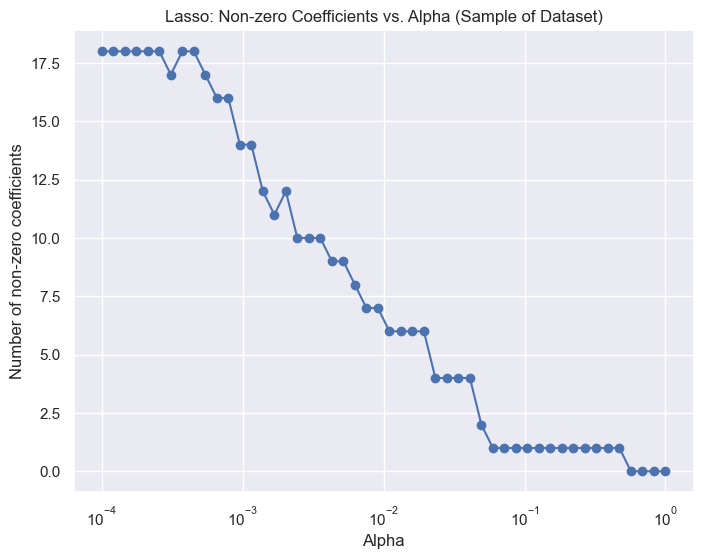

In [ ]:
sample_data = train_data_clean.sample(n=10000, random_state=42) # take a sample for faster computation

numerical_features = ['hour', 'day_of_year', 'haversine', 'log_haversine']
scaler = StandardScaler()
num_scaled = scaler.fit_transform(sample_data[numerical_features])

categorical_features = ['day_of_week', 'month', 'anomalous_period1', 'anomalous_period2',
                        'traffic_jam', 'free_roads', 'pickup_jfk', 'dropoff_jfk']
for col in categorical_features:
    sample_data[col] = sample_data[col].astype(str)
encoder = OneHotEncoder(drop='first')
cat_scaled = encoder.fit_transform(sample_data[categorical_features]).toarray()

X_sample = np.concatenate([num_scaled, cat_scaled], axis=1)
y_sample = sample_data['log_trip_duration']

alphas = np.logspace(-4, 0, 50)
nonzero_counts = []

for a in alphas:
    lasso_model = Lasso(alpha=a, max_iter=10000)
    lasso_model.fit(X_sample, y_sample)
    nonzero_count = np.sum(lasso_model.coef_ != 0)
    nonzero_counts.append(nonzero_count)


plt.figure(figsize=(8, 6))
plt.plot(alphas, nonzero_counts, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Number of non-zero coefficients')
plt.title('Lasso: Non-zero Coefficients vs. Alpha (Sample of Dataset)')
plt.grid(True)
plt.show()

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Task 15 (1 pts)**. It is often useful considering feature interactions and construct new features from original ones. Previously we have split the Manhatten map into cells and introduced the features of cell id start/finish.

Let's try the following: compute how often each pair (start cell id, end cell id) is occured in the training set and take 100 most often pairs. Encode these pairs as cathegorical feature and add -1 to the remaining situations.

**Question**: Why is this feature potentially useful? Why can't linear model find the corresponding information by itself regardless of the model's access to the information about start cell and end cell?

This feature can be useful because if there is certain patterns in routes that are travsersed more frequently with consistent path durations then the model can learn these associations more easily and better predict the trip duration for instance. The reason a linear model could potentially not find the corresponding information by itself is because it would only be possible for the model to capture linear relationships between inputs and outputs and these start-end pairs may have non linear effects on the trip duration. The model would take the cell id pickup and cell id dropoff and assign weights to them independently.  

In [159]:
grid_transformer = MapGridTransformer(nrows=10, ncols=10)
grid_transformer.fit(train_data_clean)
train_data_clean_transformed = grid_transformer.transform(train_data_clean)
pair_series = train_data_clean_transformed.apply(lambda row: (row['cell_id_pickup'], row['cell_id_dropoff']), axis=1)
pair_counts = pair_series.value_counts()

top_100_pairs = pair_counts.head(100).index.tolist()


def encode_pair(row):
    pair = (row['cell_id_pickup'], row['cell_id_dropoff'])
    return pair if pair in top_100_pairs else -1

train_data_clean_transformed['start_end_pair'] = train_data_clean_transformed.apply(encode_pair, axis=1)
train_data_clean_transformed['start_end_pair'] = train_data_clean_transformed['start_end_pair'].astype('category')

print("Top 100 pairs:")
print(pair_counts.head(100))


Top 100 pairs:
(67, 67)    966482
(77, 77)        20
(68, 68)        14
(78, 78)         5
(47, 47)         4
(-1, -1)         2
(98, 98)         1
(57, 57)         1
(9, 9)           1
(97, 97)         1
(88, 88)         1
(18, 18)         1
(30, 30)         1
Name: count, dtype: int64


Fit the model (`Ridge` or `Lasso` depending on previous observations) on the new features and compute the quality on the testing set.

In [ ]:

numerical_features = ['hour', 'day_of_year', 'haversine', 'log_haversine']
categorical_features = ['day_of_week', 'month', 'anomalous_period1', 'anomalous_period2', 
                        'traffic_jam', 'free_roads', 'pickup_jfk', 'dropoff_jfk', 'start_end_pair']

for col in categorical_features:
    train_data_clean_transformed[col] = train_data_clean_transformed[col].apply(lambda x: str(x))

scaler = StandardScaler()
num_scaled = scaler.fit_transform(train_data_clean_transformed[numerical_features])

encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
cat_scaled = encoder.fit_transform(train_data_clean_transformed[categorical_features]).toarray()

X_combined = np.concatenate([num_scaled, cat_scaled], axis=1)
y = train_data_clean_transformed['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

lasso = Lasso(alpha=0.0001, max_iter=10000)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE with all features (including start_end_pair):", rmse)


Test RMSE with all features (including start_end_pair): 0.4304017841245564
